# Library

In [1]:
import cv2
import numpy as np
import os


In [2]:
from PIL import Image as Img
from PIL import ImageTk
# dependencies
from IPython.display import Image
from matplotlib import pyplot as plt

import cv2 as cv
import argparse
import sys
import numpy as np
import os.path
import matplotlib.gridspec as gridspec

In [3]:
import matplotlib.gridspec as gridspec
# from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras_preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

In [4]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

In [5]:
# # LOAD THE IMAGE
# img = cv2.imread('./test_images/coba/mobil40.jpg')

# plt.imshow(img)
# plt.show()

# Load Model

In [6]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./static/models/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [7]:
# LOAD CHARACTER RECOGNITION MODEL
json_file = open('./model5/MobileNets_character_recognition_akudataset.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("./model5/models_cnn.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('./model5/license_character_classes_akudataset.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [8]:
# # LOAD CHARACTER RECOGNITION MODEL
# json_file = open('./model-results/character_recognition.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# model.load_weights("./model-results/models_cnn.h5")
# print("[INFO] Model loaded successfully...")

# labels = LabelEncoder()
# labels.classes_ = np.load('./model-results/character_classes.npy')
# print("[INFO] Labels loaded successfully...")

# Detect Plate

In [9]:
def get_detections(img,net):
    # CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    # FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # clean
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    # NMS
    index = np.array(cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)).flatten()
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+30),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        #cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return license_text
    
    
def crop_plate(self):
    x, y, w, h = self.coordinates
    roi = self.img[y:y + h, x:x + w]
    self.roi_image = roi
    return

In [10]:
def extract_text(bbox):
    x,y,w,h = bbox
    bbox = img[y:y+h, x:x+w]
    return bbox

In [11]:
# predictions
def yolo_predictions(img,net):
    ## step-1: detections
    input_image, detections = get_detections(img,net)
    ## step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    ## step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)

    return result_img

In [86]:
# test
img = cv2.imread('./Mobil/i_(92).jpg')
results = yolo_predictions(img,net)

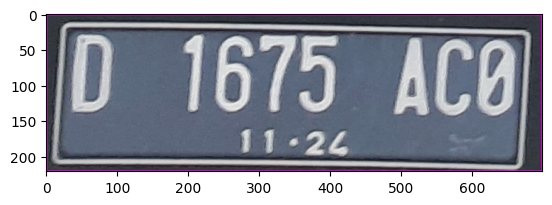

In [87]:
plt.imshow(results)
plt.show()

In [88]:
img_num = 1
        
# Save frames using cv2.imwrite
cv2.imwrite("./image_{}.jpg".format(img_num), results)  # Save image localy 
img_path = "./image_{}.jpg".format(img_num)
img_num+=1

In [89]:
# print("Image written to file-system : ",status)

# Segmentation Character Plate

In [90]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv.findContours(img.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv.contourArea, reverse=True)[:15]
    
    ii = cv.imread(img_path)
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv.resize(char, (20, 40))
            cv.drawContours(ii, [cntr], 0, (0, 255, 0), 5)
            cv.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (255,0,0), 5)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.savefig('Segmentation.jpg',bbox_inches = 'tight')        
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [91]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv.imread(image)
    img_gray_lp = cv.cvtColor(img_lp, cv.COLOR_BGR2GRAY)
    _, img_binary_lp = cv.threshold(img_gray_lp, 127, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    img_binary_lp = cv.erode(img_binary_lp, (3,3))
    img_binary_lp = cv.dilate(img_binary_lp, (3,3))
    
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/8,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.show()
    plt.axis("off")

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

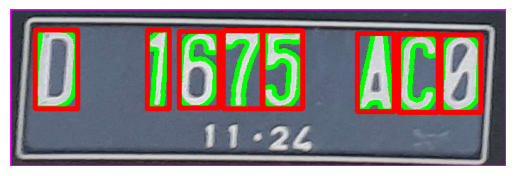

In [92]:
digits = segment_characters(img_path)

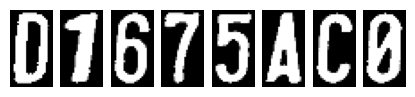

In [93]:
for i in range(len(digits)):
    plt.subplot(1, 10, i+1)
    plt.imshow(digits[i], cmap='gray')
    plt.savefig('Character Segmentation.jpg')
    plt.axis('off')

# Character Recognition

In [94]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

1/1 [==============================] - 0s 36ms/step
Plat :  01675ACO


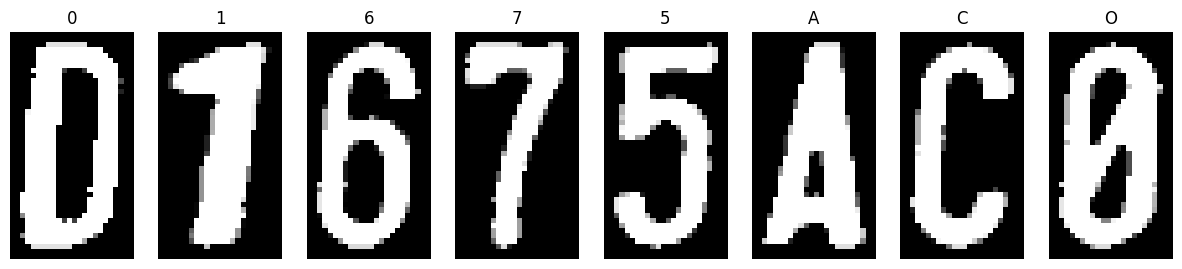

In [95]:
fig = plt.figure(figsize=(15,3))
cols = len(digits)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(digits):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character, cmap='gray')

print("Plat : ", final_string)

# Car with Number Plate

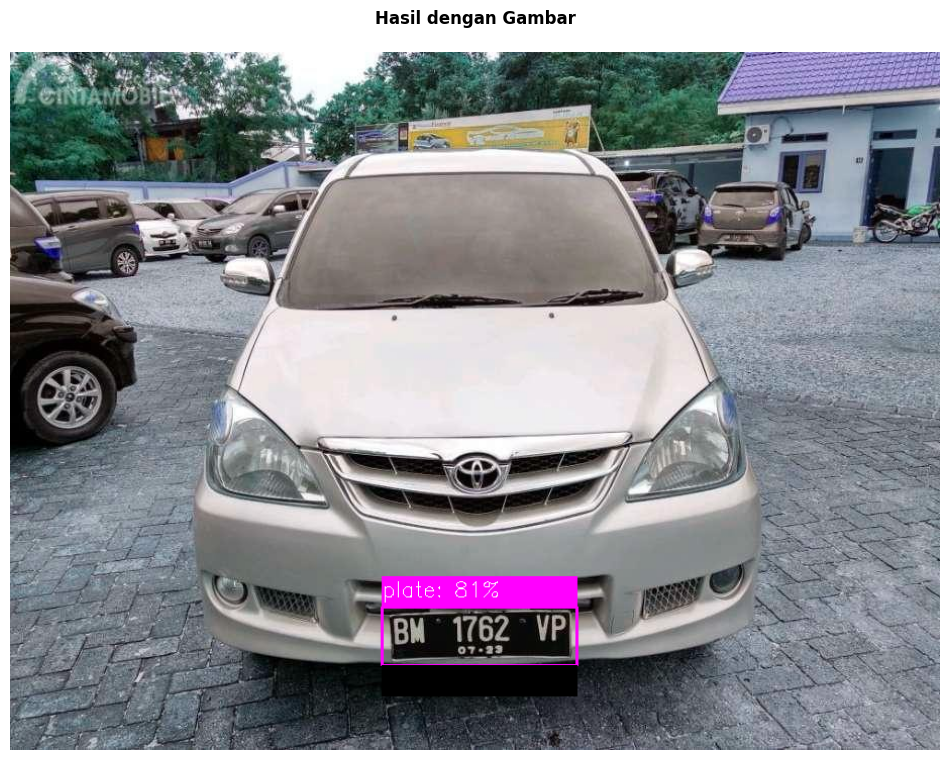

In [43]:
image = cv.imread(img_path)

# font
font = cv.FONT_HERSHEY_SIMPLEX

# org
position =  (2000,3000)
  
# fontScale
fontScale = 8
   
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 15

   
# Using cv2.putText() method
image = cv.putText(img, final_string , position, font, 
                   fontScale, color, thickness, cv.LINE_AA)
   
# Displaying the image
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.title('Hasil dengan Gambar\n',
                fontsize = 12, fontweight ='bold')
plt.axis('off')
plt.savefig('Hasil Plat.jpg',bbox_inches = 'tight')
plt.show()